***
### <font color=red>Chapter 5: TALN PII Case Study - Dataset preparation for Labeling</font>
<p style="margin-left:10%; margin-right:10%;">by <font color=teal> John Doe (typica.ai) </font></p>

***


#### Overview:
This notebook prepares a dataset for the OCI Data Labeling Service. It involves several key processes including data download, cleaning, balancing, and final transformation into Jsonl Consolidated format, suitable for labeling tasks.

# 1. Data Access:
- **Purpose:** Retrieve the dataset for use in this notebook.
- **Method:** Download the selected dataset directly into the notebook environment.

Install the hugging face datasets library (the first time).

In [ ]:
%%capture
pip install datasets

Filters out warnings

In [9]:
import warnings
warnings.filterwarnings('ignore')

Use the load_dataset() function to load the dataset from Hugging Face Hub repository by providing the dataset namespace and name i.e. TypicaAI/pii-masking-60k_fr.


In [10]:
from datasets import load_dataset
orig_dataset = load_dataset("TypicaAI/pii-masking-60k_fr")
orig_dataset

DatasetDict({
    train: Dataset({
        features: ['masked_text', 'unmasked_text', 'privacy_mask', 'span_labels', 'bio_labels', 'tokenised_text'],
        num_rows: 61918
    })
})

Strip all the columns from the downloaded dataset except unmasked_text span_labels



In [11]:
from datasets import Dataset, DatasetDict

# Assuming cleaned_dataset['train'] is a dataset object
# Select only the desired columns
streamlined_dataset = orig_dataset['train'].remove_columns([col for col in orig_dataset['train'].column_names if col not in ['unmasked_text', 'span_labels']])

# Create a new dataset with only these columns
streamlined_dataset = DatasetDict({
    'train': streamlined_dataset
})

# Print the columns to verify
streamlined_dataset

DatasetDict({
    train: Dataset({
        features: ['unmasked_text', 'span_labels'],
        num_rows: 61918
    })
})

In [12]:
streamlined_dataset['train'][0]

{'unmasked_text': "Cher Ms. Keebler, nous organisons un programme d'alphabétisation à West Shemar en collaboration avec Morissette - Russel. Contactez Hulda44@yahoo.com pour plus de détails.",
 'span_labels': "[[0, 5, 'O'], [5, 8, 'PREFIX_1'], [8, 9, 'O'], [9, 16, 'LASTNAME_1'], [16, 67, 'O'], [67, 78, 'CITY_1'], [78, 101, 'O'], [101, 120, 'COMPANYNAME_1'], [120, 132, 'O'], [132, 149, 'EMAIL_1'], [149, 171, 'O']]"}

# 2. Dataset Wrangling:
This phase ensures the dataset is primed for labeling, involving two main tasks:cleaning and balancing the dataset

### 2a. Cleaning:

- **Objective**: Remove irrelevant examples that do not contain any entities of interest.
- **Process:** Filter out entries to retain only those with relevant entities, enhancing focus and utility in labeling.

Define the **relevant_labels** list (labels to keep) and the filtering logic in the **filter_relevant_labels** function.
This function performs the following for each example from the dataset:
- checks if any of the labels within the *span_labels* field match the defined relevant labels
- cleans span_labels by keeping only relevant labels for the relevant example
- marks the example as relevant or not with a new key


In [13]:
import ast  # Import abstract syntax trees module to safely parse strings into lists

# Define relevant labels
relevant_labels = {'FIRSTNAME_1', 'MIDDLENAME_1', 'LASTNAME_1', 'AGE_1',
                   'STREET_1', 'ZIPCODE_1', 'CITY_1', 'PHONENUMBER_1', 'EMAIL_1'}

def filter_and_clean_labels(example):
    # Convert the string representation of list into an actual list
    span_labels = ast.literal_eval(example['span_labels'])

    # Check if any label in span_labels is in the relevant labels set
    is_relevant = any(label[2] in relevant_labels for label in span_labels if label[2] != 'O')

    # If the example is relevant, clean span_labels by keeping only relevant labels
    if is_relevant:
        cleaned_span_labels = [[start, end, label] for start, end, label in span_labels if label in relevant_labels]
        example['span_labels'] = str(cleaned_span_labels)  # Convert back to string if needed

    return {'is_relevant': is_relevant, 'span_labels': example['span_labels']}

The Hugging Face `datasets` library `map` function apply `filter_relevant_labels` across the dataset, cleaning `span_labels` column from irrelevant labels and adding the flag 'is_relevant' to each example based on the presence of relevant labels.
The script prints the dataset size before and after the cleaning.





In [14]:
# Apply the function across the dataset using map
dataset_with_cleaned_labels = streamlined_dataset.map(filter_and_clean_labels, batched=False)

# Filter the dataset to keep only relevant examples
cleaned_dataset = dataset_with_cleaned_labels.filter(lambda example: example['is_relevant'])

# Optionally remove the 'is_relevant' field if no longer needed
cleaned_dataset = cleaned_dataset.remove_columns(['is_relevant'])

orig_ds_count = len(orig_dataset['train'])
cleaned_ds_count = len(cleaned_dataset['train'])

print(f"Original number of examples: {orig_ds_count}")
print(f"Number of relevant examples (after cleaning): {cleaned_ds_count}")

Original number of examples: 61918
Number of relevant examples (after cleaning): 36348


In [15]:
cleaned_dataset['train'][0]

{'unmasked_text': "Cher Ms. Keebler, nous organisons un programme d'alphabétisation à West Shemar en collaboration avec Morissette - Russel. Contactez Hulda44@yahoo.com pour plus de détails.",
 'span_labels': "[[9, 16, 'LASTNAME_1'], [67, 78, 'CITY_1'], [132, 149, 'EMAIL_1']]"}

The script plots the dataset size before and after the cleaning.

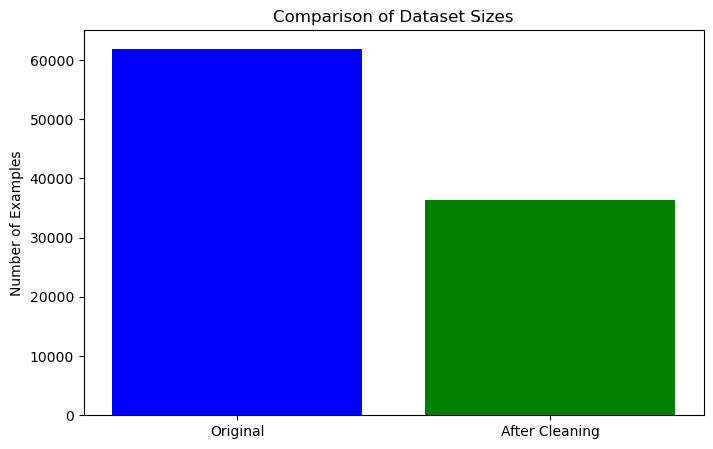

In [16]:
import matplotlib.pyplot as plt

# Data setup
categories = ['Original', 'After Cleaning']
values = [orig_ds_count, cleaned_ds_count]

# Create bar plot
plt.figure(figsize=(8, 5))
plt.bar(categories, values, color=['blue', 'green'])
plt.title('Comparison of Dataset Sizes')
plt.ylabel('Number of Examples')
plt.show()

### 2b. Balancing:

- **Objective**: Achieve a balanced representation of labeled entities to prevent model bias.
- **Process**: Adjust the dataset to ensure all entities are equally represented, using undersampling techniques as necessary.

The function `count_labels` takes the dataset as an argument and returns the counts of each label found in the `span_labels` field. Using `Counter` function from `collections` library aggregates all labels extracted from the dataset, efficiently counting occurrences of each label across all entries in the dataset.
The helper funtion `extract_labels` parses the `span_labels` from a string representation to a list, filtering out the label 'O'.


In [19]:
from collections import Counter
import ast

def extract_labels(span_labels):
    """Helper function to parse and filter labels from span_labels."""
    return [label[2] for label in ast.literal_eval(span_labels) if label[2] != 'O']

def count_labels(dataset):
    """Counts occurrences of each label in the dataset's span_labels field, excluding 'O'."""

    # Use a list comprehension to gather all labels across the dataset and count them
    label_counts = Counter(
        label for example in dataset['train']
        for label in extract_labels(example['span_labels'])
    )
    return label_counts

Define `plot_distributions` function. This function is designed to visually compare the distributions of a dataset's labels before and after the balancing step. It uses the matplotlib library to create a bar chart, which displays the counts of each label side-by-side for easy comparison. 

In [21]:
def plot_distributions(before_counts, after_counts, process="Balancing"):
    # Sort labels to ensure they match up in the plot
    labels = sorted(before_counts.keys())
    before_values = [before_counts[label] for label in labels]
    after_values = None
    if after_counts:
      after_values = [after_counts[label] for label in labels]

    x = range(len(labels))  # Label location on x-axis

    # Create the bar plot
    plt.figure(figsize=(10, 5))
    plt.bar(x, before_values, width=0.4, label=f'Before {process}', color='b', align='center')
    if after_values:
      plt.bar(x, after_values, width=0.4, label=f'After {process}', color='r', align='edge')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    plt.xlabel('Labels')
    plt.ylabel('Counts')
    plt.title(f'Label Distribution Before and After {process}')
    plt.xticks(x, labels, rotation='vertical')
    plt.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()

Calculates and prints the label distribution to assess the dataset initial balance.

In [22]:
# count labels for the cleaned dataset
label_counts = count_labels(cleaned_dataset)
print("Label Counts:", label_counts)

Label Counts: Counter({'FIRSTNAME_1': 19444, 'LASTNAME_1': 6007, 'EMAIL_1': 5130, 'AGE_1': 3856, 'STREET_1': 3741, 'MIDDLENAME_1': 3704, 'ZIPCODE_1': 3666, 'PHONENUMBER_1': 3358, 'CITY_1': 3341})


Plot the label distribution before balancing.
We notice an imbalance issue for the *first name* class `FIRSTNAME_1` label.

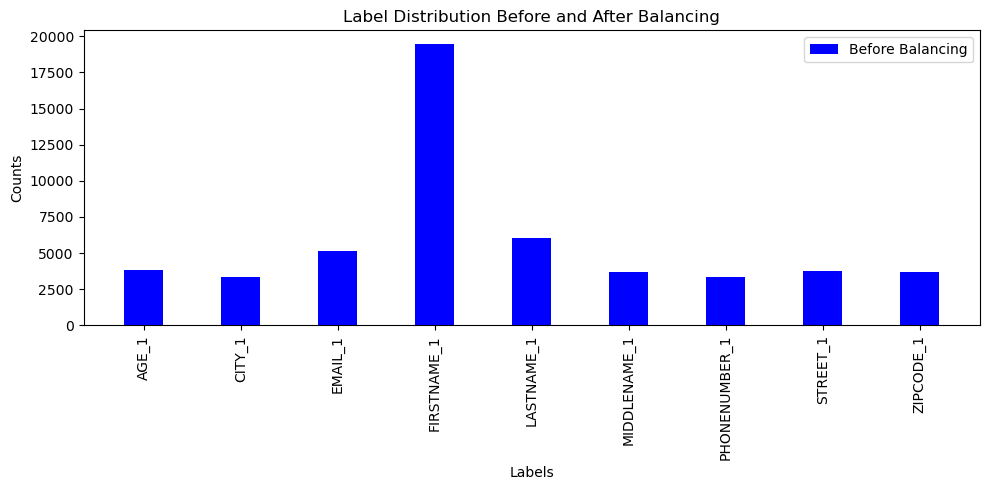

In [23]:
plot_distributions(label_counts, None)  # Plot the label counts

The `undersample_label` function applies the "Random Under-Sampling" approach to adjust the frequency of a specified label within a dataset to prevent overrepresentation. It takes as *Inputs* the  cleaned dataset, the label to be reduced ("first name" class, i.e., `FIRSTNAME_1` label), and a target maximum count (count of the `LASTNAME_1` label).

In [24]:
import random

def undersample_label(dataset, label_to_undersample, target_count):
    """Reduces the occurrences of a specified label to a target count."""
    examples_with_label = [ex for ex in dataset if label_to_undersample in extract_labels(ex['span_labels'])]
    examples_without_label = [ex for ex in dataset if label_to_undersample not in extract_labels(ex['span_labels'])]

    if len(examples_with_label) > target_count:
        examples_with_label = random.sample(examples_with_label, target_count)

    new_dataset = examples_with_label + examples_without_label
    random.shuffle(new_dataset)  # Shuffle for a uniform distribution
    return new_dataset

Apply undersampling to balance the `FIRSTNAME_1` label and create the balanced new dataset

In [25]:
# Apply undersampling to balance the 'FIRSTNAME_1' label
target_count_for_firstname = 6007  # Assuming 'LASTNAME_1' count as target
balanced_ds_list = undersample_label(cleaned_dataset['train'], 'FIRSTNAME_1', target_count_for_firstname)

# Convert the 'train' dictionary (contains a list of dictionaries) to a Hugging Face dataset
balanced_dataset = DatasetDict({
    'train': Dataset.from_dict({
    'unmasked_text': [ex['unmasked_text'] for ex in balanced_ds_list],
    'span_labels': [ex['span_labels'] for ex in balanced_ds_list]
    })
  })

balanced_dataset

DatasetDict({
    train: Dataset({
        features: ['unmasked_text', 'span_labels'],
        num_rows: 22911
    })
})

Recount and plot the label distribution after balancing

In [26]:
# Recalculate the new label counts
new_label_counts = count_labels(balanced_dataset)
print("Label Counts:", new_label_counts)

Label Counts: Counter({'FIRSTNAME_1': 6007, 'LASTNAME_1': 3772, 'EMAIL_1': 3481, 'AGE_1': 3317, 'STREET_1': 3176, 'ZIPCODE_1': 3108, 'MIDDLENAME_1': 2928, 'CITY_1': 2562, 'PHONENUMBER_1': 2544})


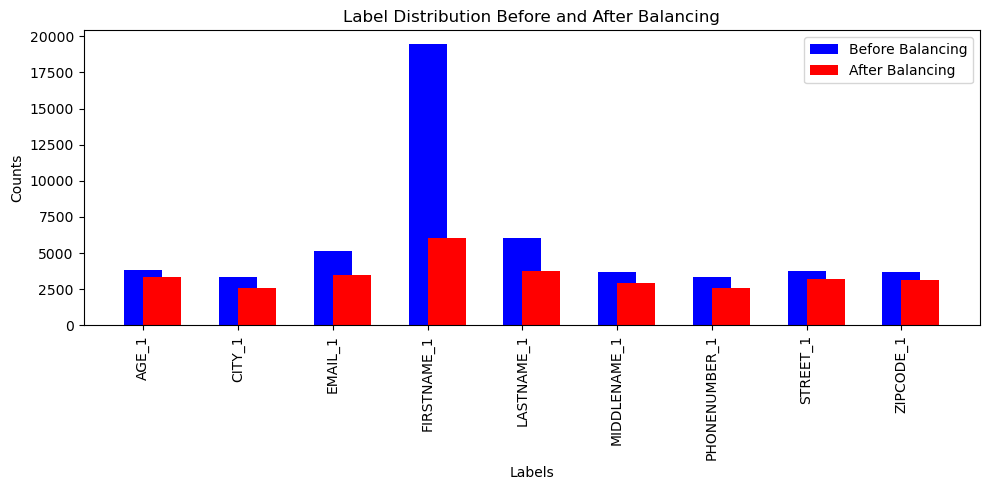

In [27]:
# plot the new label distribution
plot_distributions(label_counts, new_label_counts)  # Plot the label new counts

**Optional Step**: Check for redundant or duplicated examples in our balanced dataset before finishing with the cleaning step. This code will identify and count duplicate entries based on the `unmasked_text` field.

In [28]:
from collections import Counter

def check_duplicates(dataset):
    # Extract texts to check for duplicates
    texts = [example['unmasked_text'] for example in dataset]
    
    # Count each text's occurrences in the dataset
    text_counts = Counter(texts)
    
    # Identify texts that occur more than once
    duplicates = {text: count for text, count in text_counts.items() if count > 1}
    
    return duplicates
 
# Check duplicates for balanced_dataset
duplicates = check_duplicates(balanced_dataset['train'])

# Print out duplicates and their counts
if len(duplicates) > 0 :
    print("Duplicated entries and their counts:")
    for text, count in duplicates.items():
        print(f"Text: {text} | Count: {count}")
else:
    print("No duplicated entries were found")

No duplicated entries were found


No duplicates were found. Let's jump to the dataset transformation step.

### 2c. Transforming:

- **Objective**: Convert the balanced dataset to an OCI Data Labeling dataset (Jsonl Consolidated format).
- **Process**: Reformat the data into the required Jsonl Consolidated structure and save it to the OCI Labeling Datasets Bucket for further use.

Now that we have balanced our dataset, let's transform it into a suitable format for OCI Data Labeling `Jsonl Consolidated` and save it to our Labeling Datasets Bucket.

The code snippet, based on our balanced dataset, creates in our *Labeling Datasets Bucket* the files for our future OCI Data Labeling Dataset to be imported:
- Metadata file (JSONL Consolidated format), which includes the new dataset details and annotations for each example.
- Record files, which are text files where each one represents one example from the balanced dataset.



The default service limit for DLS record count is 10,000. If we want to avoid the record-count limit issue, we need to reduce the size of our balanced dataset. In a real-world situation, if the number of records we need to create exceeds the number of available records, you must file a regular Customer Account Management (CAM) ticket to request an increase in the limit.

In [30]:
pii_fr_dataset_v1 = balanced_dataset["train"].select(range(0,10000))
pii_fr_dataset_v1 = DatasetDict({
    'train': pii_fr_dataset_v1
  })
pii_fr_dataset_v1

DatasetDict({
    train: Dataset({
        features: ['unmasked_text', 'span_labels'],
        num_rows: 10000
    })
})

Revalidate the label distribution after the downsizing of the balanced dataset

In [31]:
# Recalculate the new label counts
pii_fr_dataset_v1_label_counts = count_labels(pii_fr_dataset_v1)
print("Label Counts:", pii_fr_dataset_v1_label_counts)

Label Counts: Counter({'FIRSTNAME_1': 2641, 'LASTNAME_1': 1646, 'EMAIL_1': 1473, 'AGE_1': 1438, 'STREET_1': 1418, 'ZIPCODE_1': 1400, 'MIDDLENAME_1': 1254, 'PHONENUMBER_1': 1136, 'CITY_1': 1134})


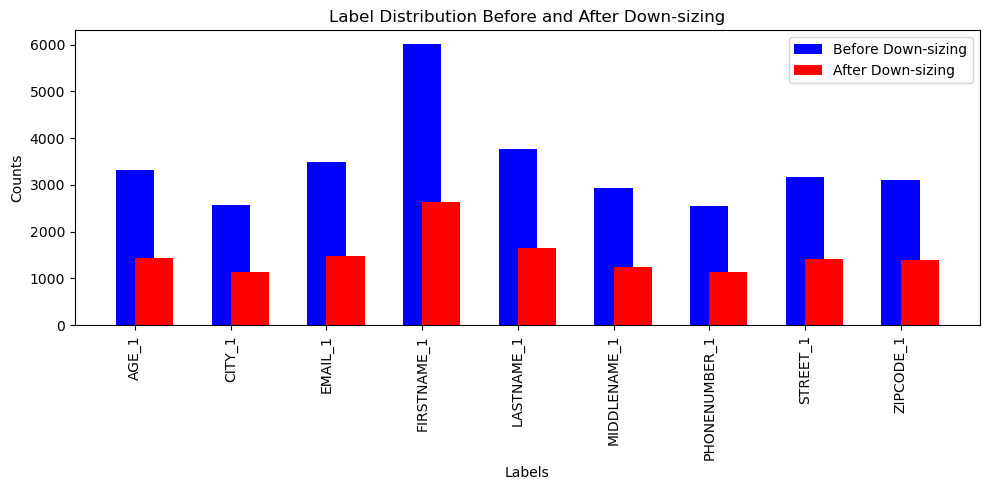

In [36]:
# Plot the balanced label count vs. downsized label counts
plot_distributions(new_label_counts, pii_fr_dataset_v1_label_counts, "Down-sizing")

The downsized dataset is balanced enough for our case study.

At this stage, we can save the downsized dataset to the `training_datasets_bkt` as a restore point for this dataset or for later use (if needed).

In [37]:
pii_fr_dataset_v1.save_to_disk('/home/datascience/buckets/training_datasets_bkt/pii_fr_dataset_v1.0.0')

Saving the dataset (0/1 shards):   0%|          | 0/10000 [00:00<?, ? examples/s]

Let's create the OCI Data Labeling dataset in Jsonl Consolidated format.

In [38]:
import oci
from datasets import load_dataset
import json
import io
import os
import tempfile
from tqdm import tqdm

# Initialize OCI Object Storage Client with notebook session's resource principal
signer = oci.auth.signers.get_resource_principals_signer()
object_storage_client = oci.object_storage.ObjectStorageClient(config={}, signer=signer)

# Initialize Object Storage bucket infos
namespace = object_storage_client.get_namespace().data
bucket_name = "labelling_datasets_bkt"

# Base folder in the bucket
base_folder = "pii_fr_dataset_v1.0.0/"

# Function to strip "_1" from labels
def strip_label(label):
    return label.rsplit("_", 1)[0] if "_" in label else label

labels_set = set()
annotations_list = []

for idx, item in enumerate(tqdm(pii_fr_dataset_v1["train"], 
                                desc="processing dataset records", 
                                total=len(pii_fr_dataset_v1["train"])
                               )
                          ):
    text = item['unmasked_text']
    span_labels = eval(item['span_labels'])  # Convert string to list if necessary

    # Prepare annotations for this row
    entities = []
    for start, end, label in span_labels:
        label = strip_label(label)
        labels_set.add(label)  # Add to the set of unique labels
        entities.append({
            "entityType": "TEXTSELECTION",
            "labels": [{"label_name": label}],
            "textSpan": {"offset": start, "length": end - start}
        })

    if len(entities) > 0:
        file_name = f"rec-{idx}.txt"
        annotations_list.append({
            "sourceDetails": {"path": file_name},
            "annotations": [{"entities": entities}]
        })

        # Upload the text to OCI bucket
        record_filename = f"{base_folder}{file_name}"
        record_body = io.BytesIO(text.encode('utf-8'))
        
        object_storage_client.put_object(namespace,
                                         bucket_name,
                                         record_filename,
                                         record_body,
                                         content_type='text/plain')
        
# Prepare the dataset metadata, i.e., JSONL Metadata
dataset_details = {
    "displayName": "PII Fr Dataset v1.0.0",
    "description": "PII Case Study - Dataset ready for adding credit card-related labels and annotations using OCI Data Labeling Service.",
    "labelsSet": [{"name": label} for label in labels_set],
    "annotationFormat": "ENTITY_EXTRACTION",
    "datasetFormatDetails": {"formatType": "TEXT"}
}

# Metadata and annotations as JSONL string
jsonl_data = json.dumps(dataset_details) + '\n' + '\n'.join(json.dumps(annotation) for annotation in annotations_list)

# Write the metadata and annotations to a JSONL file
# Use tempfile to create a temporary file for JSONL content
with tempfile.NamedTemporaryFile(delete=False, mode='w', suffix='.jsonl') as tmpfile:
    json.dump(dataset_details, tmpfile)
    tmpfile.write('\n')
    for annotation in annotations_list:
        json.dump(annotation, tmpfile)
        tmpfile.write('\n')
    tmpfile_path = tmpfile.name  # Save the path for uploading

# Upload the JSONL file to OCI bucket
with open(tmpfile_path, 'rb') as f:
    objStoreResp = object_storage_client.put_object(namespace,
                                                    bucket_name,
                                                    f"{base_folder}dataset_metadata.jsonl",
                                                    f,
                                                    content_type='application/json'  # Set the Content-Type for the object
                                                   )

print(f'The Dataset {dataset_details["displayName"]} was created successfully in the bucket {bucket_name}')

# Optionally delete the temporary file
os.remove(tmpfile_path)

processing dataset records: 100%|██████████| 10000/10000 [04:57<00:00, 33.62it/s]


The Dataset PII Fr Dataset v1.0.0 was created successfully in the bucket labelling_datasets_bkt
